# Analyze Boston - Track 1: Reducing Boston’s Carbon Footprint

Ignacio Carracedo / nachocarracedo@gmail.com

----------------------------

**1. INTRODUCTION** 

**2. REQUIREMENTS**

**3. DATA PREPARATION **
   
**4. VISUALIZATIONS **

    4.1. MAP    
    4.2. BUILDINGS  
    4.3. BUILDINGS' TYPE    
    4.4. DECADE BUILT

---------------------------------------

## 1. INTRODUCTION

In order to achieve a carbon neutral Boston by 2050 the city needs a good tracking system to explore the BERDO data. Tracking how buildings are doing through the years can yield valuable information. This information can then be used to focus on certain buildings. The information can also be used to understand what factors affect greenhouse gas emissions.

This notebook is a prototype that explores metrics to track. The information on this notebook can them be used to create a tracking app/dashboard.

The first step is to cleaning the data and then, to provide some visualization examples that show the change from 2014 to 2015. I focus on tracking how greenhouse emissions changed from 2014 to 2015, comparing these results with the energy consumption, water used, and the share of each energy source (electricity, gas, steam). 

It's important to understand that as of today, only 2 years’ worth of data is available which limits the amount of information we can extract, but as years go by the system can be improved.


----------------------------------------------

## 2. REQUIREMENTS

This section shows the modules and versions used to ran this notebook:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'

import requests
import warnings
warnings.filterwarnings('ignore')

%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,requests

2017-04-28 

CPython 3.6.0
IPython 5.1.0

numpy 1.11.3
pandas 0.19.2
matplotlib 2.0.0
requests 2.12.4

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


----------------------------------------------

## 3. DATA PREPARATION

First, we load the available BERDO datasets (2014, 2015) and I join them using the features `Address` and `Property Name`.

In [2]:
# read data
berdo2015 = pd.read_csv(".//data/berdo2015.csv",
                        encoding = "ISO-8859-1")
berdo2014 = pd.read_csv(".//data/berdo2014.csv",
                        encoding = "ISO-8859-1")

# sizes
print("Size of BERDO 2014 data set: %s" %(berdo2014.shape[0]))
print("Size of BERDO 2015 data set: %s" %(berdo2015.shape[0]))
print("\n........ Merging ........\n")

# merge
berdo = pd.merge(berdo2015,
                 berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014')) # sufixes for both data sets

# final size
print("Size of joined BERDO data set: %s" %(berdo.shape[0]))

Size of BERDO 2014 data set: 1380
Size of BERDO 2015 data set: 1502

........ Merging ........

Size of joined BERDO data set: 1085


I found 1085 matches. Some buildings didn't match; a simple typo would have left some listing out of the final data set. This step can be improved checking individual entries.

For tracking porpouses, I am interested in the following features:

* **Property Name**: Property name, as reported by owner
* **Address**: Reported address
* **Site EUI (kBTU/sf)**: Site energy use intensity, or EUI (in kBTU/sq. ft.): This sums up all of the energy used in the building (electricity, gas, steam, etc.) each year, and divides by square footage. There are many drivers of energy use intensity, such as energy-intensive work, and, since EUI is not adjusted for these factors, it is not a definitive indicator of building efficiency. (This metric uses site energy, not source energy.)
* **Property Uses**: List of space uses reported for this property
* **Year Built**: Year built, as reported by the owner
* **GHG Intensity (kgCO2/sf)**: GHG intensity (kgCO2/sf) divides total GHG emissions by square footage.
* **Total Site Energy (kBTU)**: Total energy used in 2014 (kBTU). This is a gross sum of all annual energy use in the building, not adjusted for size or uses.
* **% Electricity**: Percent of total energy that is electricity
* **% Gas**: Percent of total energy that is gas
* **% Steam**: Percent of total energy that is steam
* **Water Intensity (gal/sf)**:	Water intensity (gal/sf); the total water use divided by gross floor area.

Here are the steps taken to clean the data:

* `fix_numerical`: `string` columns that are considered numerical are transformed into a number
* `fix_percenteage`: percent columns are transformed  into numbers
* bad values are transformed  into `-1`. This values will later be removed (depending on how many there are)

In [3]:
cols_num = ['Gross Area (sq ft)',
            'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)',
            'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ',
            'Water Intensity (gal/sf)',
            'Energy Star Score'            
           ]

cols_percent = ["% Gas",
                "% Steam",
                "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%",
                                inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columns
fix_numerical(cols_num)
fix_percenteage(cols_percent)

Next, I fix the following features:

* `Year Built`: I set to 0 all years before 1600. These entries should be typos (remember that the data was entered by the users).Then, I create a feature `decade`, this will allow us to explore buidings by the decade they were built in.

* `Water Intensity (gal/sf)`: If water measure for any year is 0 it means that there was an error measuring or that the building  wasn't being used, thus, we can not track it so both values for that buildings are set to 0. Then, we flag these buildings using the feature `water_null`.

In [4]:
# calculates total enery to see if it adds up to 100%
berdo["%_total_2015"] = berdo[["% Gas_2015",
                               "% Steam_2015",
                               "% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014",
                               "% Steam_2014",
                               "% Electricity_2014"]].sum(axis=1)

# fix 'year built' 
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: 
                                                        0 
                                                        if x<1600
                                                        else x)

# create feature `decade`
berdo["decade"] = berdo["Year Built_2015"].map(lambda x:
                                               int(str(x)[:-1]+"0") 
                                               if x>1 
                                               else x)


# fix water, if one year is null, set to 0,0 both 
berdo["Water Intensity (gal/sf)_2014"].fillna(value=0,inplace=True)
berdo["Water Intensity (gal/sf)_2014"].replace(to_replace=-1, value=0, inplace=True)
berdo["Water Intensity (gal/sf)_2015"].fillna(value=0,inplace=True)
berdo["Water Intensity (gal/sf)_2015"].replace(to_replace=-1, value=0, inplace=True)


def fix_water_2014(row):
    "if 2015 is null or 0, it sets to 0 both of them"
    if row['Water Intensity (gal/sf)_2015']==0:
        return 0
    else:
        return row['Water Intensity (gal/sf)_2014']
    
def fix_water_2015(row):
    "if 2014 is null or 0, it sets to 0 both of them"
    if row['Water Intensity (gal/sf)_2014']==0:
        return 0
    else:
        return row['Water Intensity (gal/sf)_2015']

berdo["Water Intensity (gal/sf)_2014"] = berdo.apply(fix_water_2014,axis=1)
berdo["Water Intensity (gal/sf)_2015"] = berdo.apply(fix_water_2015,axis=1)
# flag unreliable entries to 1
berdo["water_null"] = berdo["Water Intensity (gal/sf)_2015"].map(lambda x: 1 if x==0 else 0)

I noticed that sometimes, the value of energy use of a year is much higher than the value of the other year, which was almost nonexistent. This is due to the building being renovated. To avoid counting these buildings when tracking energy/ghg I create a new `feature` that flags buildings as being renovated or under construction for a particular year. When plotting we'll remove these buildings.

Shown below is a list of buildings being flagged:

In [5]:
def possible_construction (row):
    """ if energy difference is higher by more than 100 times
        the row is mark as 1. Otherwise 0 """
    
    y2015 = row["Site EUI (kBTU/sf)_2015"]
    y2014 = row["Site EUI (kBTU/sf)_2014"]
    if y2015 > y2014:
        if y2015/y2014 > 100:
            return 1
        else:
            return 0
    else:
        if y2014/y2015 > 100:
            return 1
        else:
            return 0

berdo["under_construction"] = berdo.apply(possible_construction, axis=1)

# show possible "UNDER CONSTRUCTION"
berdo[berdo["under_construction"] == 1][["Property Name","Address",
                                         "Site EUI (kBTU/sf)_2015",
                                         "Site EUI (kBTU/sf)_2014",
                                         "GHG Intensity (kgCO2/sf)_2015",
                                         "GHG Intensity (kgCO2/sf)_2014"]]

,Property Name,Address,Site EUI (kBTU/sf)_2015,Site EUI (kBTU/sf)_2014,GHG Intensity (kgCO2/sf)_2015,GHG Intensity (kgCO2/sf)_2014
106,230 Congress Street,230 Congress Street,25693.9,219.1,1712.0,20.5
119,26 Irwin Av,26 Irwin Av,200.3,1.5,11.3,0.1
197,543-547 Washington Street,543-547 Washington Street,166.6,73235.1,13.3,4865.0
379,BROOKLINE ICE,225 SOUTHHAMPTON ST,5634.3,34.9,545.1,3.4
691,Landmark at Longwood,63 Parket Hill Road,75.7,0.2,7.3,0.0
1081,YMCA of Greater Boston - Constitution Inn,150 Second Avenue,61.3,25348.8,3.8,1347.5
1082,YMCA of Greater Boston - Huntington,316 Huntington Avenue,202.8,69141.5,13.4,3674.6


Now, I remove missing values/bad data:

* All rows with -1 on any column.
* All rows where `under_construction` is 1.

106 observations out of 1085 were removed due to either missing values or bad data. 

In [6]:
print("Size before removing bad/missing values: %s" %berdo.shape[0])

# remove under construction
berdo = berdo[berdo.under_construction != 1]

# feature selection
berdo = berdo[["Property Name","Address","ZIP_2015",
               "Year Built_2015","decade",
               "Property Type_2015","Property Type_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014",
               "Water Intensity (gal/sf)_2015","Water Intensity (gal/sf)_2014",
               "water_null"
              ]]


# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)

print("Size after removing bad/missing values: %s" %berdo.shape[0])

Size before removing bad/missing values: 1085
Size after removing bad/missing values: 979


Now, I create a final `Data.Frame` called `berdo_diff` that will have the difference between the year 2015 and 2014.

2015 data will be subtracted from 2014 data, thus, positive values mean a decrease (2014 data was higher than 2015 data) and negative values mean there was an increase.

In [7]:
# new data frame
berdo_diff = pd.DataFrame()

# property info
berdo_diff[["property_name", "address",
            "zip","year_built","decade"]] = berdo[["Property Name",
                                                   "Address","ZIP_2015",
                                                   "Year Built_2015","decade"]]
# property type
berdo_diff[["property_type_2015",
            "property_type_2014"]] = berdo[["Property Type_2015",
                                            "Property Type_2014"]]

# energy diff
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2014"] \
                                  - berdo["Site EUI (kBTU/sf)_2015"]

# ghg diff
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2014"] \
                                          - berdo["GHG Intensity (kgCO2/sf)_2015"]
    
# energy %
berdo_diff[["%_electricity_2015",
            "%_gas_2015",
            "%_steam_2015"]] = berdo[["% Electricity_2015",
                                      "% Gas_2015",
                                      "% Steam_2015"]]
berdo_diff[["%_electricity_2014",
            "%_gas_2014",
            "%_steam_2014"]] = berdo[["% Electricity_2014",
                                      "% Gas_2014",
                                      "% Steam_2014"]]


# water diff
berdo_diff["water_null"] = berdo["water_null"]   
berdo_diff["water_intensity_gal/sf_diff"] = berdo["Water Intensity (gal/sf)_2014"] \
                                          - berdo["Water Intensity (gal/sf)_2015"]

def water_set_null (row):
    """ sets water_diff to NaN if the buiding's
        feature 'water_null' is 1"""
    
    if row["water_null"] == 1:
        return np.NaN
    else:
        return row["water_intensity_gal/sf_diff"]
    
berdo_diff["water_intensity_gal/sf_diff"] = berdo_diff.apply(water_set_null,axis=1)

To introduce the visualization section I want to plot the buildings on a map, thus, we need the latitude and longitude of the buildings. I used google maps API (`get_long_lat`) to look for the address and extract both longitude and latitude. The process is run a second time (`redo_long_lat`) in case some API calls timed out the first iteration.

In [8]:
import requests

def get_long_lat(address):
    """receives a Boston address and looks for longitude 
       and latitude using google maps API. Returns string 
       with both values. Values are 0 if error """
    
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
            + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)


def redo_long_lat(row):
    """if the field lat_long is '0 0'
       the function tries to retrieve longitude 
       and latitude from google maps API"""
    
    if row["lat_long"] == "0 0":
        address = row["address"]  
        fix_add = address.replace(" ","+")
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' \
                + fix_add + ',+Boston,+Massachusetts,+USA'
        try:        
            response = requests.get(url)
            resp_json_payload = response.json()
            info = (resp_json_payload['results'][0]['geometry']['location'])
            return str(info['lat'])+" "+str(info['lng'])
        except:
            return "0 0" 
    else:
        return row["lat_long"]

berdo_diff["lat_long"] =  berdo_diff.apply(redo_long_lat, axis=1)

# creates features longitude and latitude
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

# save
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

----------------------------------------------

## 4. VISUALIZATIONS

### 4.1 MAP

To introduce the data set we plot all buildings using longitude and latitude. I create 3 maps; the 1st map is colored using the  energy intensity difference between 2014 and 2015. The 2nd map does the same using greenhouse gas intensity. The 3rd map uses the water difference. The colors represent the following:

* Increase: value in 2015 was higher than in 2014 (red)
* Neutral: value in 2015 was the same as in 2014 (orange)
* Decrease: value in 2015 was lower than in 2014 (green)

This is a way to get quick an overview of how things are doing (for instance, seeing all green in the second map would be Mayor Walsh dream! ) 

In [ ]:
# loads data to start executing notebook from this cell
# berdo_diff = pd.read_csv("./data/berdo_diff.csv")

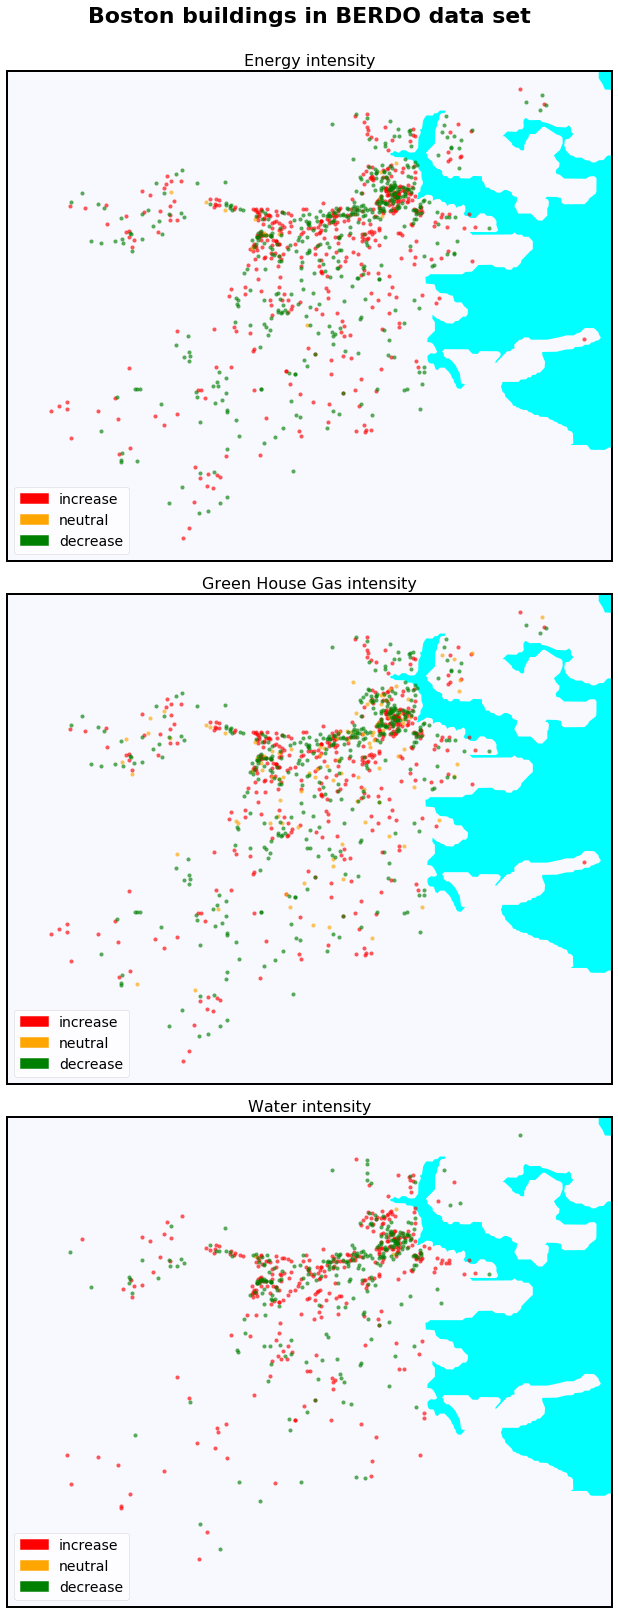

In [9]:
# boston limits
west, south, east, north = -71.1958, 42.2254, -70.9804, 42.40

# figure
fig = plt.figure(figsize=(12,22),
                 facecolor='white')
plt.suptitle("Boston buildings in BERDO data set", y=1.02, fontsize=22,fontweight = 'bold')

##################################################### ENERGY MAP
fig.add_subplot(311)
plt.title("Energy intensity", size=16)

# coloring split
increase = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['energy_kbtu/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north, 
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='ghostwhite',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="aqua")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 
m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='orange',
       alpha=0.65,
       markeredgecolor='orange',
       markeredgewidth=0.05) 
m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='orange',
                              label='neutral')
green_patch = mpatches.Patch(color='green',
                             label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch]
              ,loc='lower left')

for text in l.get_texts():
    text.set_color("black")
    
    
##################################################### GHG MAP
fig.add_subplot(312)
plt.title("Green House Gas intensity", size=16)

# coloring split
increase = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')

m.fillcontinents(color='ghostwhite',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="white")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 
m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='orange',
       alpha=0.65,
       markeredgecolor='orange',
       markeredgewidth=0.06) 
m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='orange',
                              label='neutral')
blue_patch = mpatches.Patch(color='blue',
                            label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch],
               loc='lower left')

for text in l.get_texts():
    text.set_color("black")
    
##################################################### WATER MAP
fig.add_subplot(313)    
plt.title("Water intensity", size=16)

# coloring split
increase = berdo_diff[berdo_diff['water_intensity_gal/sf_diff'] < 0]
neutral = berdo_diff[berdo_diff['water_intensity_gal/sf_diff'] == 0]
decrease = berdo_diff[berdo_diff['water_intensity_gal/sf_diff'] > 0]

# map
m = Basemap(llcrnrlat=south,
            urcrnrlat=north,
            llcrnrlon=west,
            urcrnrlon=east,
            lat_ts=south,
            resolution='f')
m.fillcontinents(color='ghostwhite',
                 lake_color='aqua')
m.drawmapboundary(color='black',
                  linewidth=2,
                  fill_color='aqua')
m.drawrivers(color="white")

# points
m.plot(increase["long"].values,
       increase["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.65,
       markeredgecolor='red',
       markeredgewidth=0.05) 
m.plot(neutral["long"].values,
       neutral["lat"].values,
       'bo', 
       markersize=4,
       color='orange',
       alpha=0.65,
       markeredgecolor='orange',
       markeredgewidth=0.05) 
m.plot(decrease["long"].values,
       decrease["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.65,
       markeredgecolor='green',
       markeredgewidth=0.05) 

#legend
red_patch = mpatches.Patch(color='red',
                           label='increase')
yellow_patch = mpatches.Patch(color='orange',
                              label='neutral')
blue_patch = mpatches.Patch(color='blue',
                            label='decrease')

l = plt.legend(handles=[red_patch,
                        yellow_patch,
                        green_patch],
               loc='lower left')

for text in l.get_texts():
    text.set_color("black")

# show figure    
plt.tight_layout()    
plt.show()

From the maps above we see where the buildings are located. Most of them are in Downtown and Back bay.

We also get a sense on what progress is being done in terms of energy/ghg/water.

### 4.2 BUILDINGS

Now we  drill down on specific buildings. It's important to notice the correlation between energy difference (`energy_kbtu/sf_diff`) and greenhouse gas difference (`ghg_intensity_kgco2/sf_diff`): 

In [10]:
berdo_diff[["ghg_intensity_kgco2/sf_diff",
            "energy_kbtu/sf_diff",
            "water_intensity_gal/sf_diff"]].corr(method='pearson')

,ghg_intensity_kgco2/sf_diff,energy_kbtu/sf_diff,water_intensity_gal/sf_diff
ghg_intensity_kgco2/sf_diff,1.000000,0.999821,0.001240
energy_kbtu/sf_diff,0.999821,1.000000,0.001206
water_intensity_gal/sf_diff,0.001240,0.001206,1.000000


Based on this correlation I will plot greenhouse difference instead of energy difference.

Let's start with the 20 buildings that had the largest increase in greenhouse emissions (per sqft) and need some improvement. This is the info we will extract from these 20 buildings:

1st plot:

* GHG difference
* water difference

2nd plot:

* Electricity, gas, and steam share of total energy

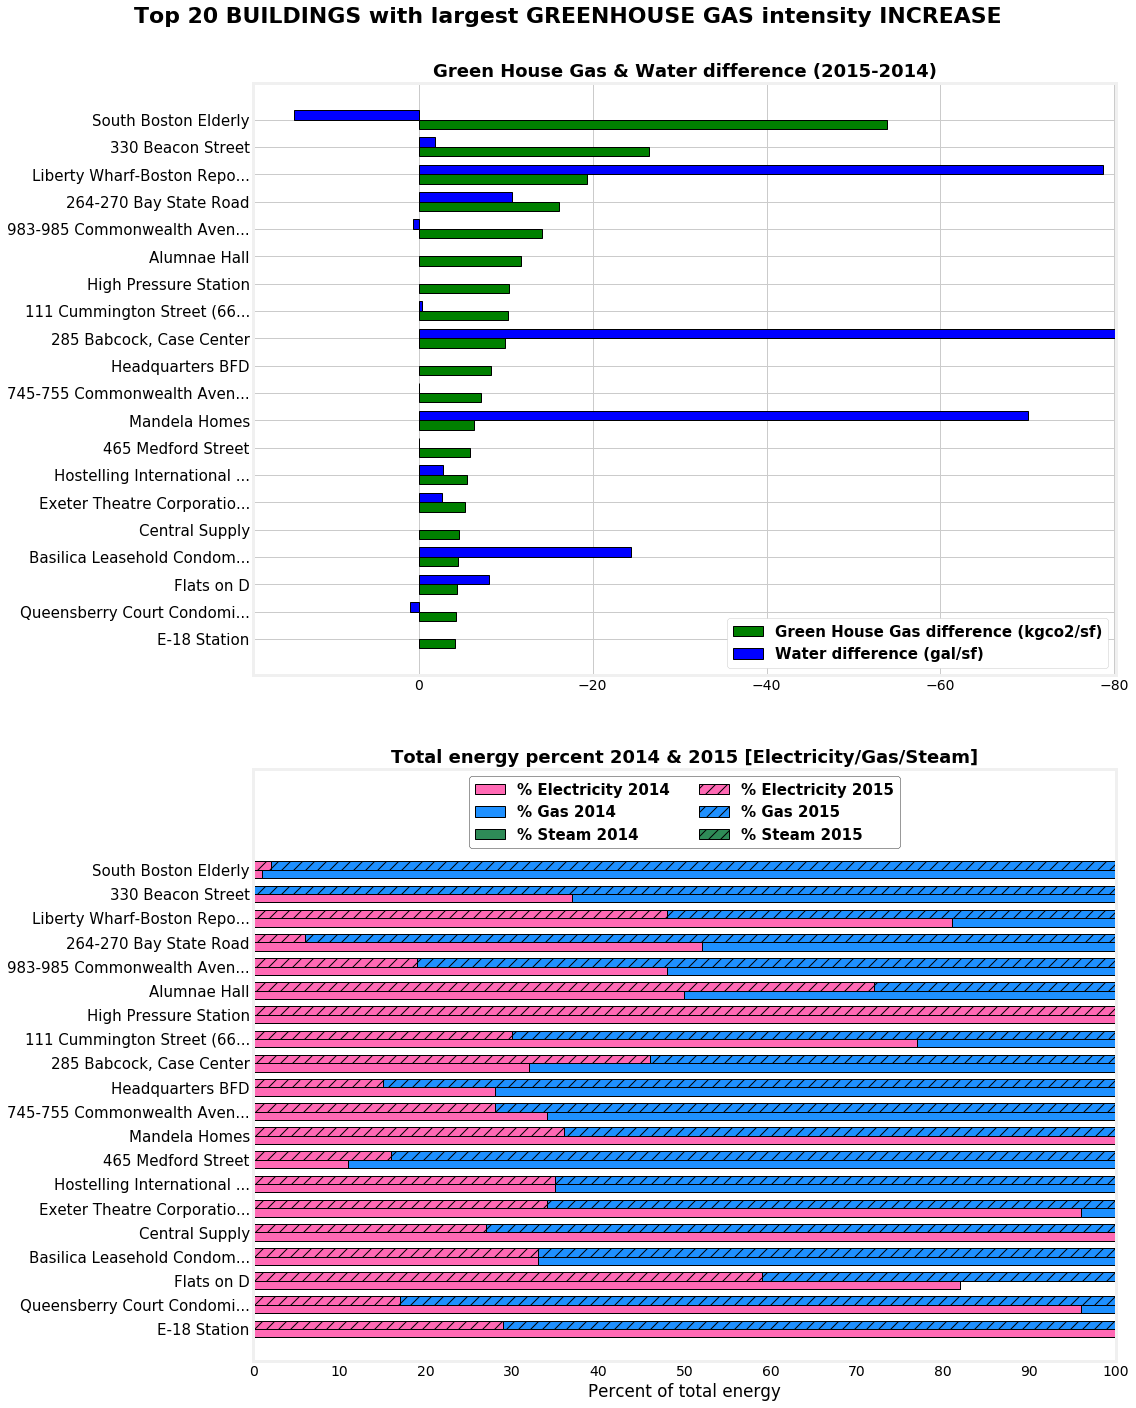

In [11]:
######################## TOP20 WORST - DIFF PLOT
# data to plot
c = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff']).iloc[:20]
# trims property name to 25 characters so it fits the plot
c['property_name'] = c['property_name'].map(lambda x: x[:25]+'...' if len(x)>25 else x)

# plot 
plt.figure(figsize=(16, 19),
           facecolor='white')

plt.suptitle("Top 20 BUILDINGS with largest GREENHOUSE GAS intensity INCREASE",
             y=1.03,
             fontweight='bold',
             fontsize=22)

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Green House Gas & Water difference (2015-2014)",
          size=18,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=aa,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="g",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)
p2 = ax.barh(bottom=bb,
             width=c["water_intensity_gal/sf_diff"].values,
             color="b",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c['property_name']], size=15)

# legend
plt.legend((p1[0],p2[0]),
           ('Green House Gas difference (kgco2/sf)',
            'Water difference (gal/sf)'),
            loc='lower right',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TOP20 WORST- PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff']).iloc[:20]
bad_energy_share['property_name'] = bad_energy_share['property_name'].map(lambda x: x[:25]+'...' if len(x)>25 else x)

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))
plt.title("Total energy percent 2014 & 2015 [Electricity/Gas/Steam]",
          size=18,
          fontweight = 'bold')

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
             linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"])

plt.yticks(ind-4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.property_name], size=15)
ax1.grid(False)
ax1.invert_yaxis()

plt.xlabel('Percent of total energy')
plt.xticks(np.arange(0,101,10))

# legend
plt.legend((w1[0], w2[0],w3[0], v1[0], v2[0], v3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

# show figure    
plt.tight_layout(h_pad=4)   
plt.show()

We observe that if the greenhouse emissions increased, then, the water consumption also increased or stayed the same (except for a few buildings). We also see that most of these buildings had an increase in the percent of gas they use and a decrease in electricity. This links gas use to higher greenhouse gas emissions.

Next, we'll do the same for the 20 buildings with the largest decrease of greenhouse gas emissions:

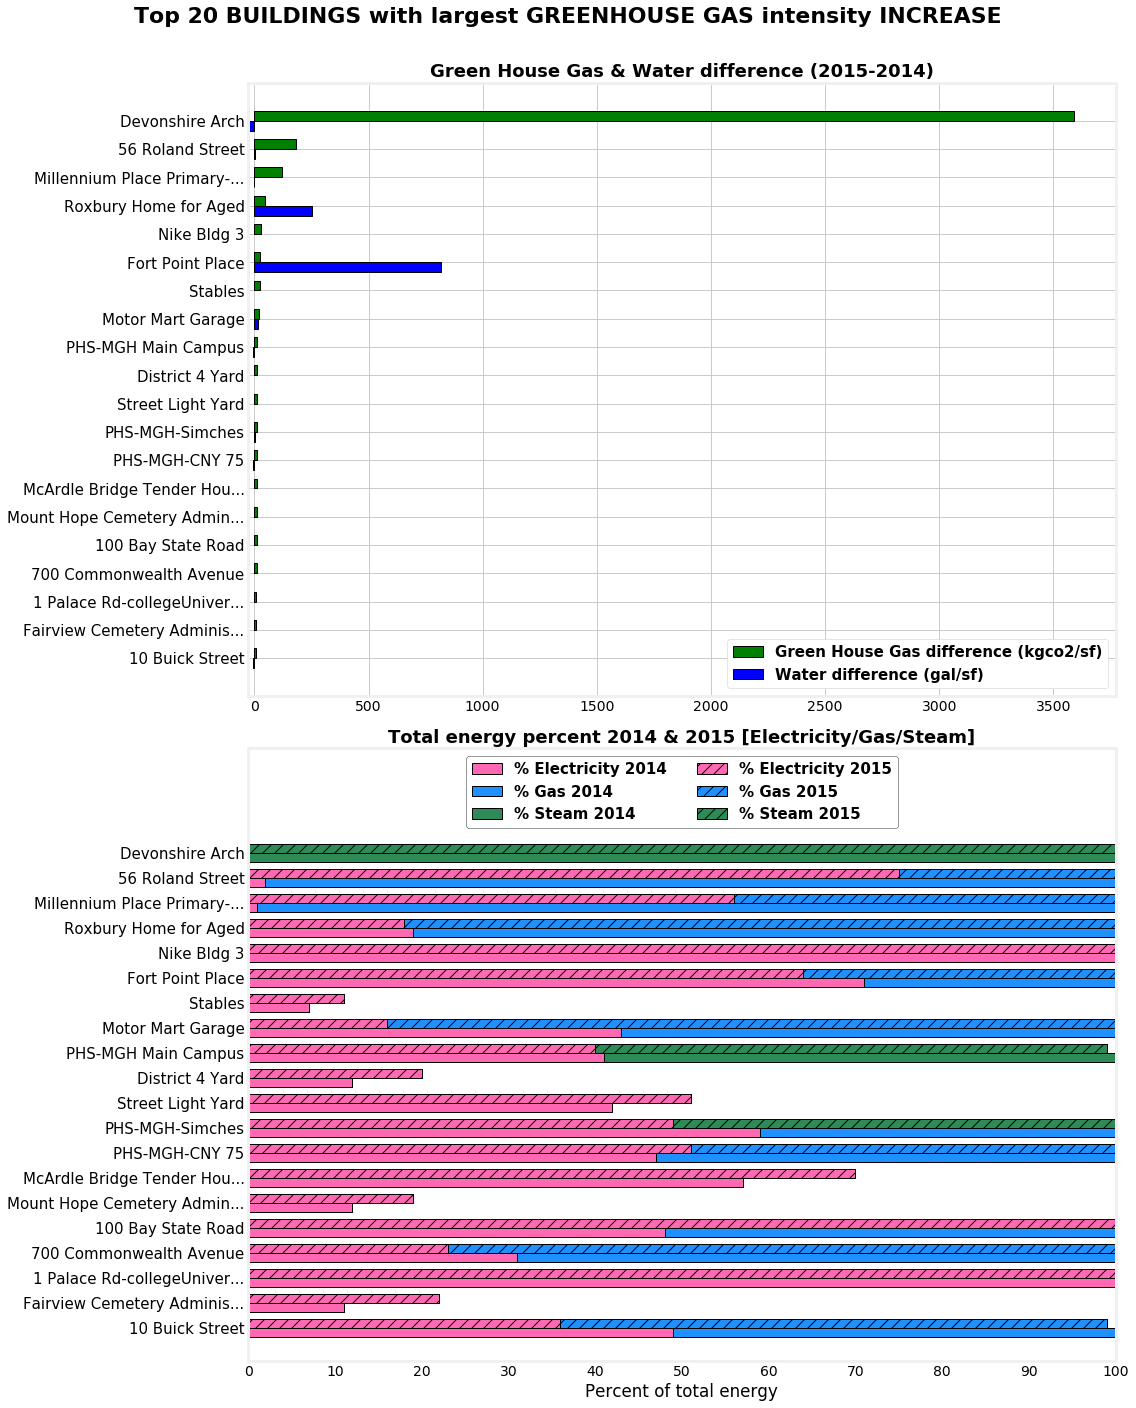

In [12]:
######################## TOP20 BEST - DIFF PLOT

# data to plot
c = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff'],ascending=False).iloc[:20]
c['property_name'] = c['property_name'].map(lambda x: x[:25]+'...' if len(x)>25 else x)

# plot 
plt.figure(figsize=(16, 19),
           facecolor='white')
plt.suptitle("Top 20 BUILDINGS with largest GREENHOUSE GAS intensity INCREASE",
             y=1.03,
             fontweight='bold',
             fontsize=22)

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Green House Gas & Water difference (2015-2014)",
          size=18,
          fontweight = 'bold')


width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=bb,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="g",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

p2 = ax.barh(bottom=aa,
             width=c["water_intensity_gal/sf_diff"].values,
             color="b",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width,)

ax.invert_yaxis()
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c['property_name']], size=15)

# legend
plt.legend((p1[0],p2[0]),
           ('Green House Gas difference (kgco2/sf)',
            'Water difference (gal/sf)'),
            loc='lower right',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TOP20 BEST - PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.sort(columns=['ghg_intensity_kgco2/sf_diff'],ascending=False).iloc[:20]
bad_energy_share['property_name'] = bad_energy_share['property_name'].map(lambda x: x[:25]+'...' if len(x)>25 else x)

#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))
plt.title("Total energy percent 2014 & 2015 [Electricity/Gas/Steam]",
          size=18,
          fontweight = 'bold')

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
             linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"])

plt.yticks(ind-4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.property_name], size=15)
ax1.grid(False)
ax1.invert_yaxis()

plt.xlabel('Percent of total energy')
plt.xticks(np.arange(0,101,10))

# legend
plt.legend((w1[0], w2[0],w3[0],v1[0], v2[0],v3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

# show figure    
plt.tight_layout()    
plt.show()

Same takeaways from previous plot. As expected a decrease of gas usually yields less greenhouse emissions. 

### 4.3 BUILDINGS' TYPE

Next buildings are grouped by building type using the average value for the metrics. Energy difference is shown instead of water difference to test for correlations when grouping.

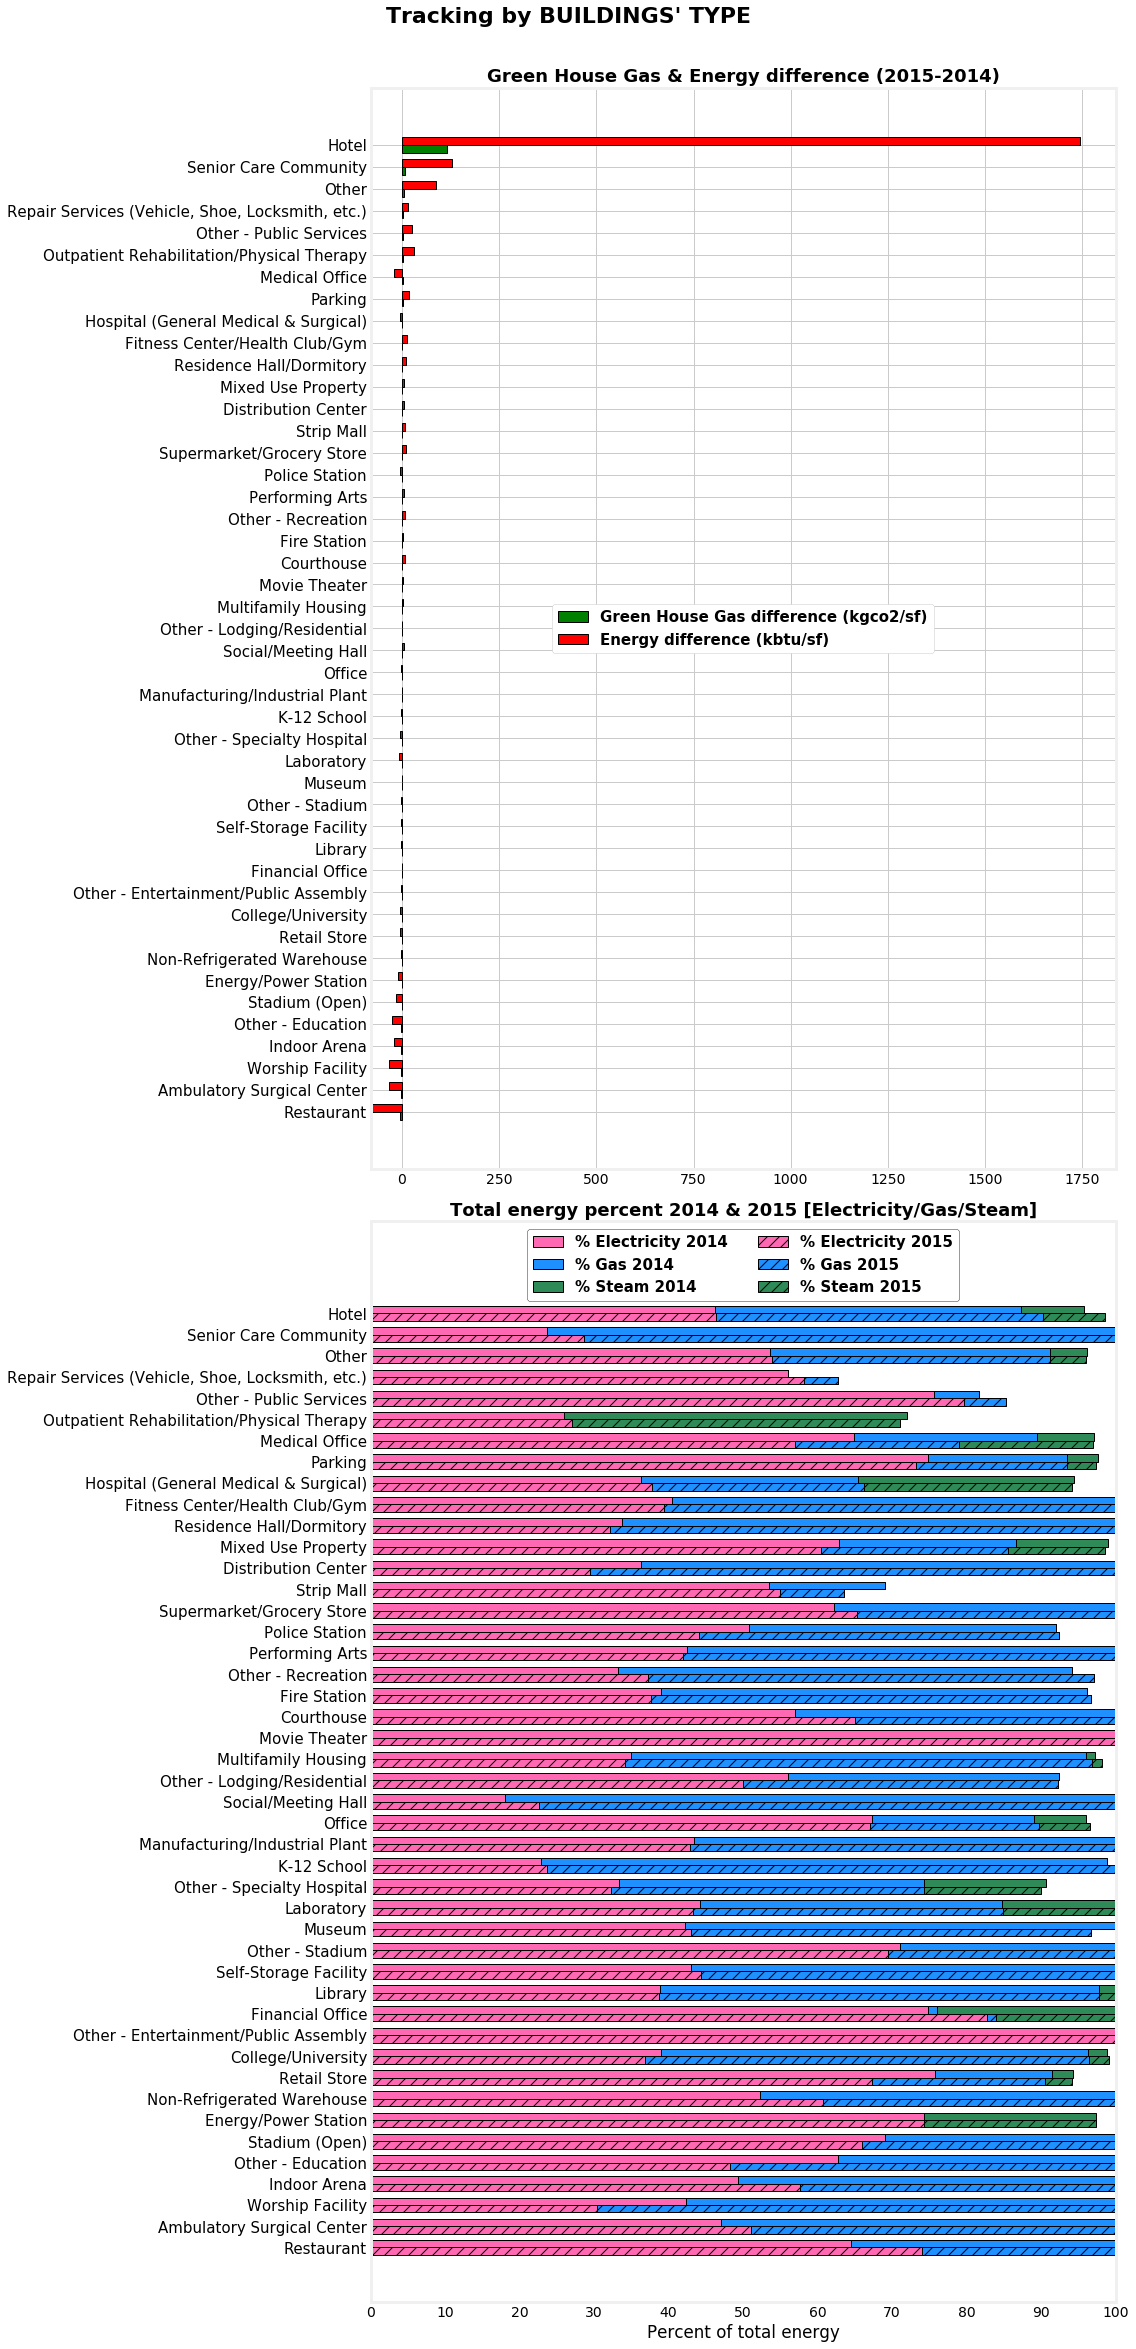

In [13]:
######################## TYPE PROPERTY -  DIFF PLOT
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].mean().sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].mean().sort_values()
c = pd.concat([a, b], axis=1).sort_values(by='ghg_intensity_kgco2/sf_diff')

# plot 
plt.figure(figsize=(16, 32),
           facecolor='white')
plt.suptitle("Tracking by BUILDINGS' TYPE",
             y=1.02,
             fontweight='bold',
             fontsize=22)

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Green House Gas & Energy difference (2015-2014)",
          size=18,
          fontweight = 'bold')

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

p1 = ax.barh(bottom=aa,
             width=c["energy_kbtu/sf_diff"].values,
             color="r",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width,)
p2 = ax.barh(bottom=bb,
             width=c["ghg_intensity_kgco2/sf_diff"].values,
             color="g",
             align="center",
             edgecolor = "black",
             linewidth = 1,
             height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])
ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas difference (kgco2/sf)',
            'Energy difference (kbtu/sf)'),
            loc='center',
            prop={'size':15,'weight':'bold'},
            framealpha=1)


######################## TYPE PROPERTY - PERCENT ENERGY PLOT
# data to plot
bad_energy_share = berdo_diff.groupby(["property_type_2015"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                        "%_gas_2014","%_steam_2014","%_electricity_2015",
                                        "%_gas_2015","%_steam_2015"]].mean()
bad_energy_share= pd.concat([c,bad_energy_share], axis=1).sort('ghg_intensity_kgco2/sf_diff')


#stacked bars
aa=  [x+width for x in range(len(bad_energy_share.index))]
bb = [x for x in range(len(bad_energy_share.index))]

ind = np.arange(len(bad_energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))
plt.title("Total energy percent 2014 & 2015 [Electricity/Gas/Steam]",
          size=18,
          fontweight = 'bold')

w1 = ax1.barh(aa,
              bad_energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              bad_energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              bad_energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
            linewidth = 1)
v2 = ax1.barh(bb,
              bad_energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              bad_energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

plt.yticks(ind+4.5) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in bad_energy_share.index], size=15)
ax1.grid(False)
plt.xlabel('Percent of total energy')
plt.xticks(np.arange(0,101,10))

# legend
plt.legend((w1[0], w2[0],w3[0],v1[0], v2[0],v3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

plt.tight_layout()
plt.show()

### 4.4. DECADE BUILT

The last plot groups buildings by the decade they were built.

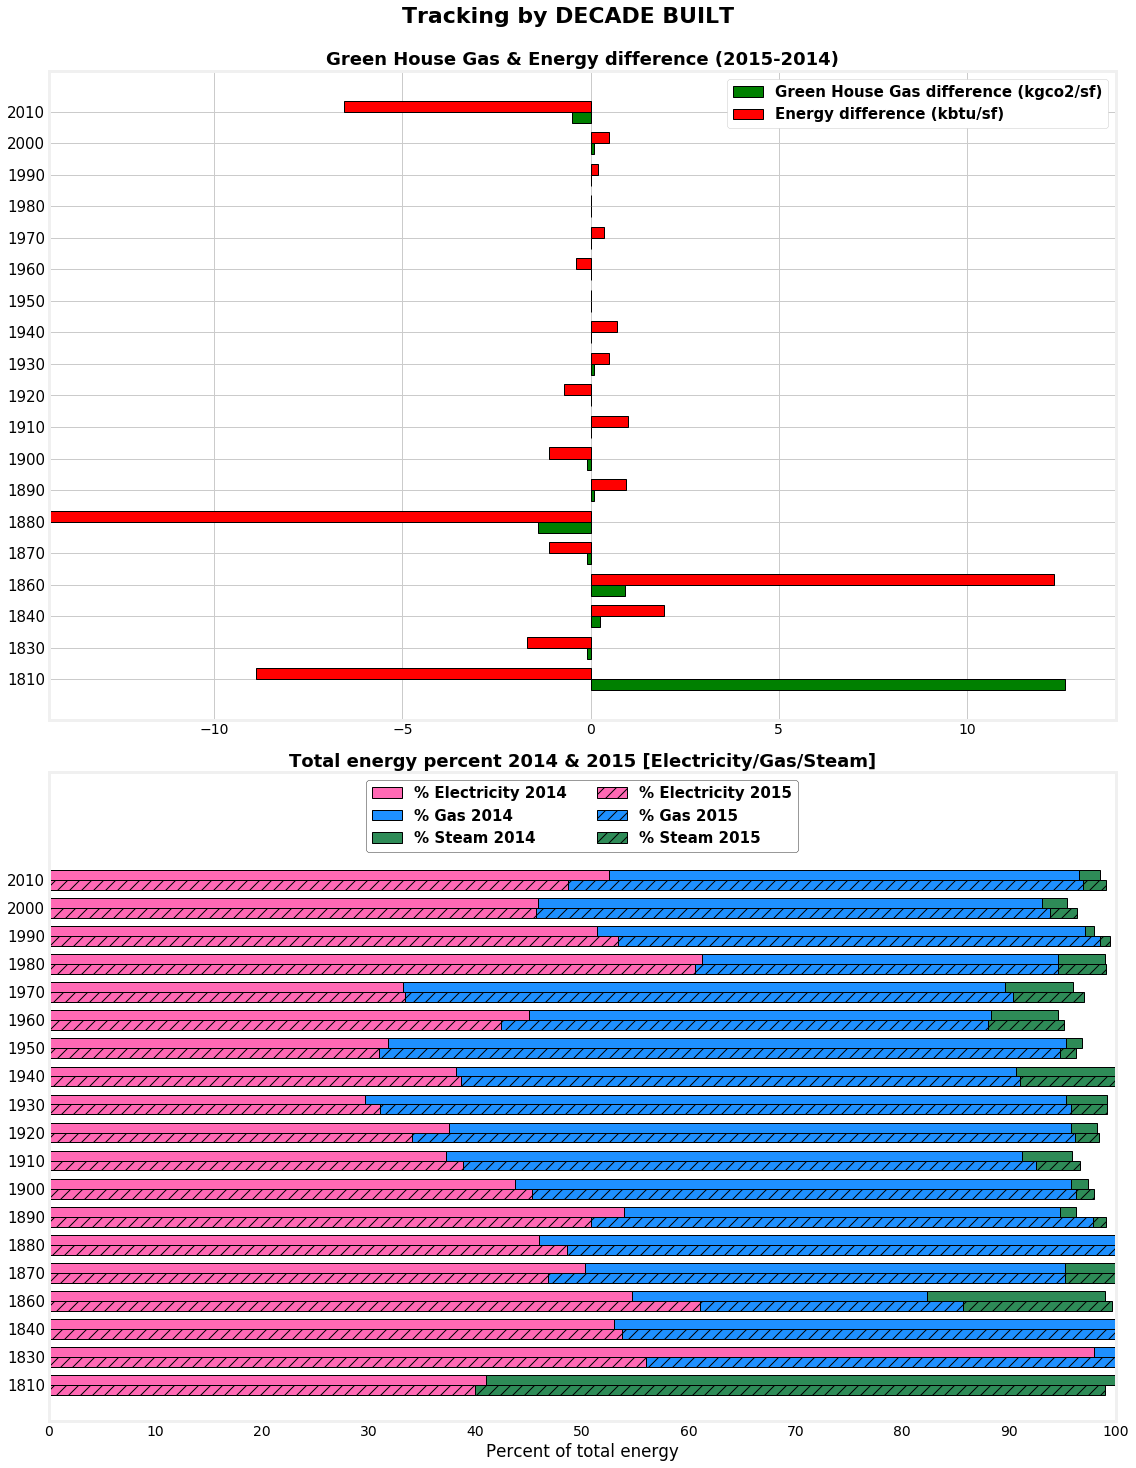

In [14]:
# data to plot
a = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['energy_kbtu/sf_diff'].median().sort_values()
    
b = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['ghg_intensity_kgco2/sf_diff'].median().sort_values()
    
stde = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['energy_kbtu/sf_diff'].std().sort_values().fillna(0).rename("energy_std")
    
stdg = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])\
            ['ghg_intensity_kgco2/sf_diff'].std().sort_values().fillna(0).rename("ghg_std")
    
c = pd.concat([a, b,stde,stdg], axis=1).sort_index()

# plot
plt.figure(figsize=(16, 20),
           facecolor='white')
plt.suptitle("Tracking by DECADE BUILT",
             y=1.02,
             fontweight='bold',
             fontsize=22)

ax=plt.subplot2grid((2,1), (0,0))
plt.title("Green House Gas & Energy difference (2015-2014)",
          size=18,
          fontweight = 'bold')
width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
p1 = ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="r", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)
p2 = ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="g",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
plt.legend((p2[0],p1[0]),
           ('Green House Gas difference (kgco2/sf)',
            'Energy difference (kbtu/sf)'),
            loc=0,
            prop={'size':15,'weight':'bold'},
            framealpha=1)

######################## TYPE PROPERTY - PERCENT ENERGY PLOT
# data to plot
energy_share = berdo_diff[berdo_diff.decade > 1].groupby(["decade"])[['energy_kbtu/sf_diff',"%_electricity_2014",
                                        "%_gas_2014","%_steam_2014","%_electricity_2015",
                                        "%_gas_2015","%_steam_2015"]].mean()
energy_share= pd.concat([c,energy_share], axis=1).sort_index()


#stacked bars
aa=  [x+width for x in range(len(energy_share.index))]
bb = [x for x in range(len(energy_share.index))]

ind = np.arange(len(energy_share))  

ax1=plt.subplot2grid((2,1), (1,0))
plt.title("Total energy percent 2014 & 2015 [Electricity/Gas/Steam]",
          size=18,
          fontweight = 'bold')

w1 = ax1.barh(aa,
              energy_share["%_electricity_2014"],
              width,
              align="center",
              color='hotpink',
              edgecolor = "black",
              linewidth = 1)
w2 = ax1.barh(aa,
              energy_share["%_gas_2014"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              left= energy_share["%_electricity_2014"])
w3 = ax1.barh(aa,
              energy_share["%_steam_2014"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              left= energy_share["%_electricity_2014"]+energy_share["%_gas_2014"])

v1= ax1.barh(bb,
             energy_share["%_electricity_2015"],
             width,
             align="center",
             color='hotpink',
             edgecolor = "black",
             hatch="//",
            linewidth = 1)
v2 = ax1.barh(bb,
              energy_share["%_gas_2015"], 
              width,
              align="center",
              color="dodgerblue",
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= energy_share["%_electricity_2015"])
v3 = ax1.barh(bb,
              energy_share["%_steam_2015"],
              width,
              align="center",
              color='seagreen',
              edgecolor = "black",
              linewidth = 1,
              hatch="//",
              left= energy_share["%_electricity_2015"]+energy_share["%_gas_2015"],)

plt.yticks(ind+4) # to fit legend
ax1.set_yticks([x+width/2 for x in ind])
ax1.set_yticklabels([x for x in energy_share.index], size=15)
ax1.grid(False)

plt.xlabel('Percent of total energy')
plt.xticks(np.arange(0,101,10))
# legend
plt.legend((w1[0], w2[0],w3[0],v1[0], v2[0],v3[0]),
           ('% Electricity 2014',
            '% Gas 2014',
            '% Steam 2014',
            '% Electricity 2015',
            '% Gas 2015',
            '% Steam 2015'
           ),
            prop={'size':15,'weight':'bold'},
            loc='upper center', 
            edgecolor = "black",
            ncol=2)

plt.tight_layout()
plt.show()

Oldest buildings show a larger difference than buildings build more recently. We can also see how the use of energy has changed over the years.

This plot ends the notebook. Next stepts will include prototipyn more methods to track how buildings are changes to end up with a dashboard that automaticaty loads and presents the inforation to the user

----------------